# **Importing libraries and reading the dataset**

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from data_processing import optimise_memory

# Reading data
df = optimise_memory(pd.read_csv('heart_failure_clinical_records_dataset.csv'))

In [ ]:
display(df)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


# **Managing Outliers**

## **Retriving and visualizing outliers** ##

In [ ]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df):
    outliers = {}
    for col in df.select_dtypes(include=np.number):  # Select solely numerical columns
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

# Application on the dataframe
outliers_dict = detect_outliers_iqr(df)

# Displaying the outliers for each column
for col, values in outliers_dict.items():
    print(f"Outliers in {col}:")
    print(values, "\n")


Outliers in age:
Series([], Name: age, dtype: float64) 

Outliers in anaemia:
Series([], Name: anaemia, dtype: int64) 

Outliers in creatinine_phosphokinase:
1      7861
38     2656
46     1380
52     3964
60     7702
72     5882
103    5209
107    1876
130    1808
134    4540
139    1548
147    1610
149    2261
153    1846
163    2334
164    2442
171    3966
176    1419
187    1896
200    1767
208    2281
227    2794
246    2017
250    2522
280    2695
283    1688
295    1820
296    2060
297    2413
Name: creatinine_phosphokinase, dtype: int64 

Outliers in diabetes:
Series([], Name: diabetes, dtype: int64) 

Outliers in ejection_fraction:
64     80
217    70
Name: ejection_fraction, dtype: int64 

Outliers in high_blood_pressure:
Series([], Name: high_blood_pressure, dtype: int64) 

Outliers in platelets:
7      454000.0
15      47000.0
47     451000.0
55     461000.0
69     497000.0
105    621000.0
109    850000.0
117    507000.0
162    448000.0
163     75000.0
167     70000.0
200  

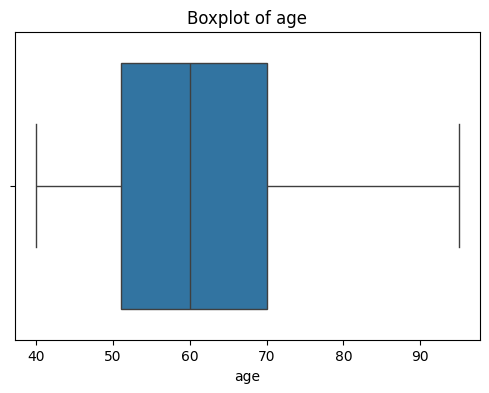

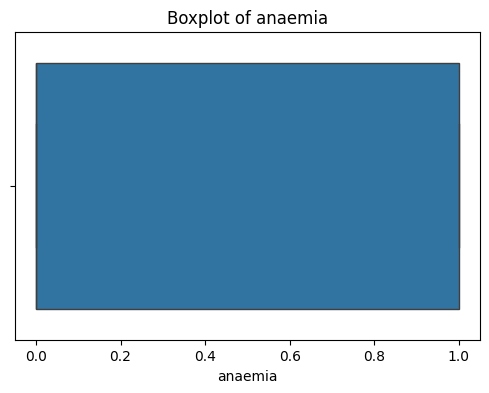

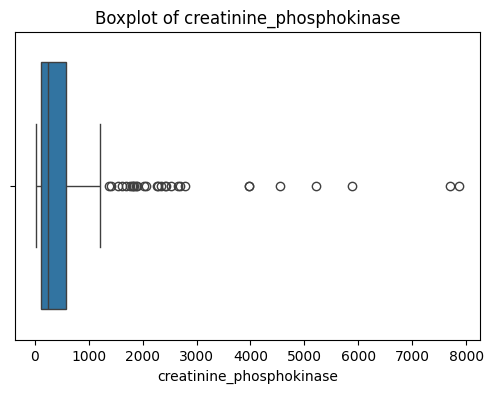

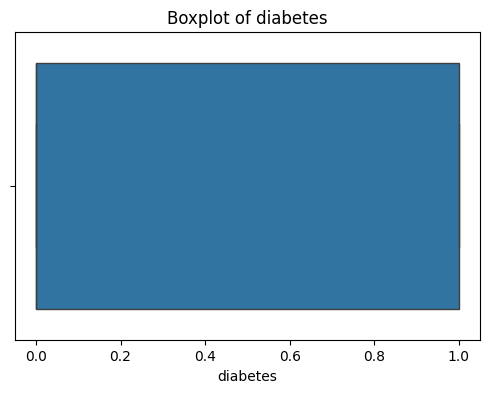

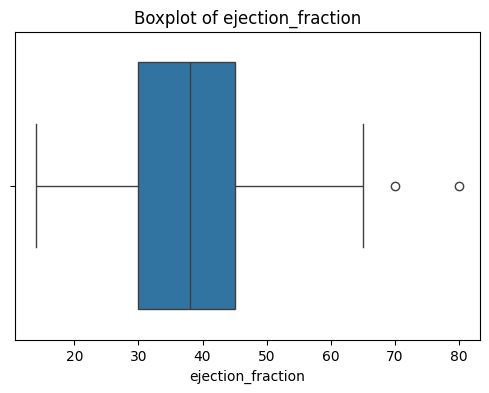

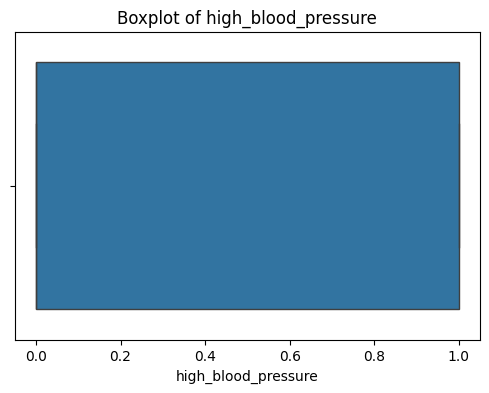

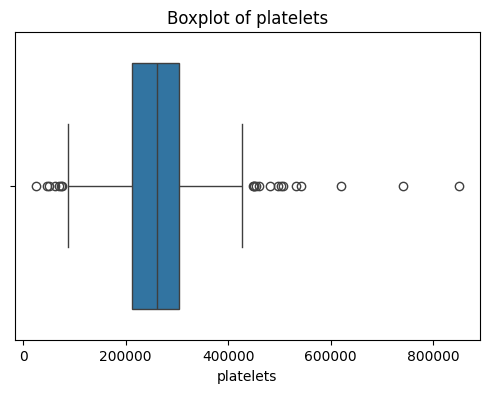

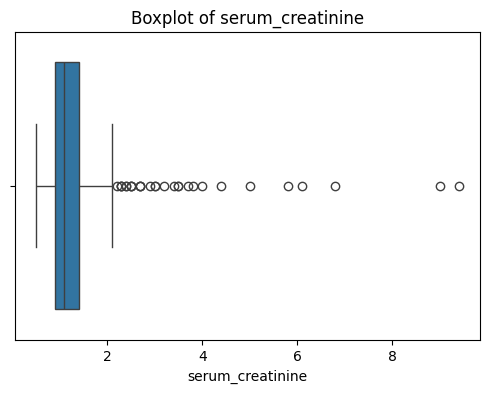

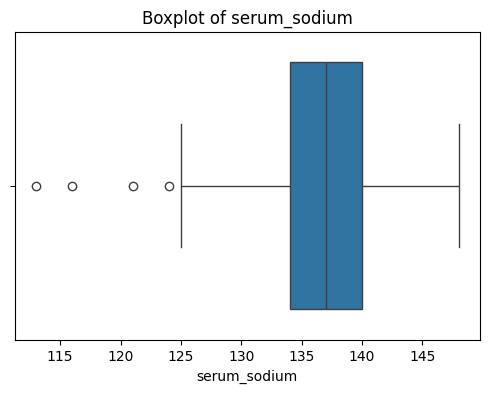

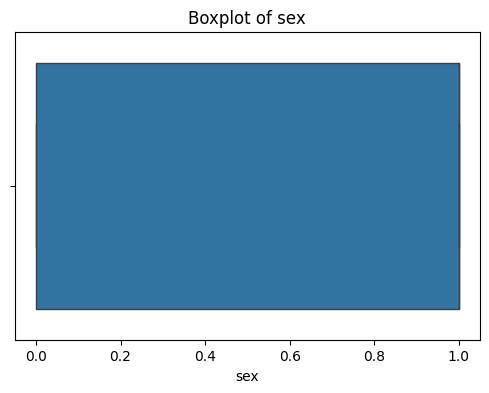

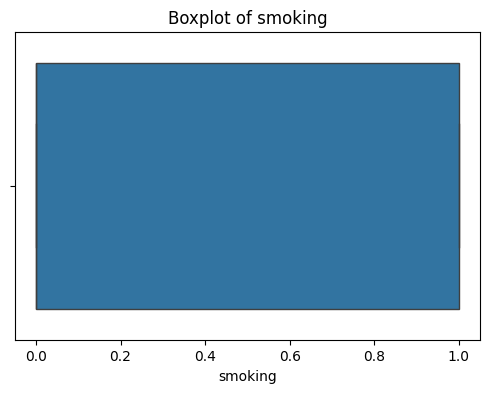

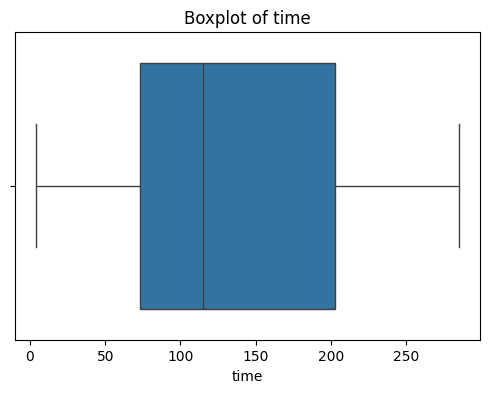

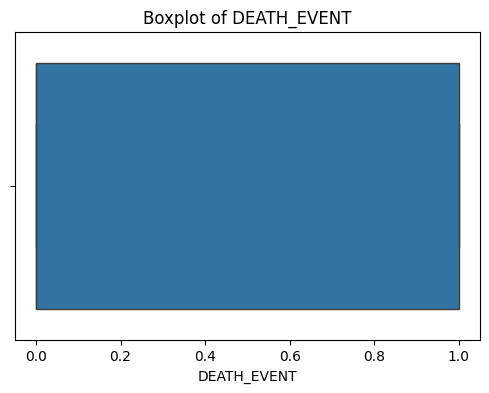

In [ ]:
# Loop through each numerical column and create a boxplot
for column in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


## **Transforming outliers**

In [ ]:
df_copy=df.copy() # une copie de la data
df_copy.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [ ]:
cont_features = ["serum_sodium","serum_creatinine","ejection_fraction","creatinine_phosphokinase"]
other_features = ["age","anaemia","diabetes","high_blood_pressure","sex","smoking","time"]
features = cont_features + other_features + ["platelets"]
# Dictionary to store Box-Cox lambdas
boxcox_lambdas = {}

#  Fit Box-Cox on the training data and store lambda values
for col in cont_features:
    if (df_copy[col] <= 0).any():  # Ensure all values are positive
        df_copy[col] += abs(df_copy[col].min()) + 1
    df_copy[col], lambda_val = boxcox(df_copy[col])  # Apply Box-Cox
    boxcox_lambdas[col] = lambda_val  # Store lambda value

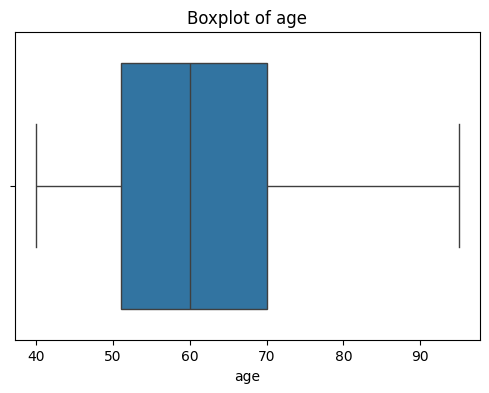

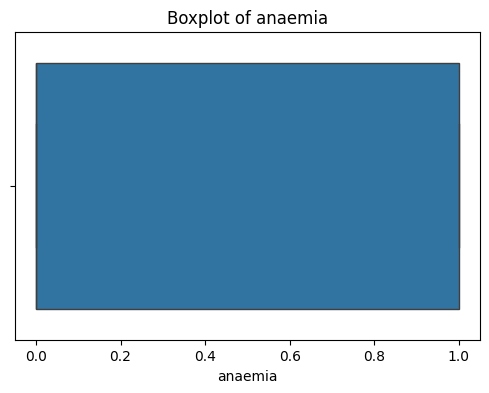

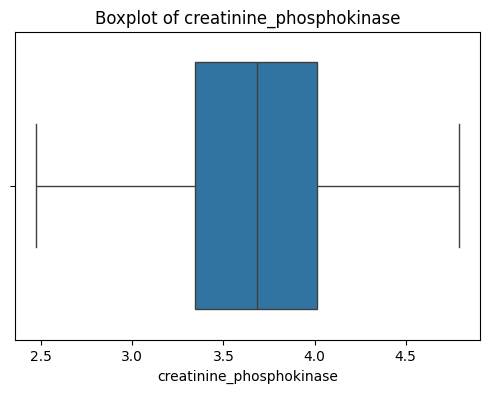

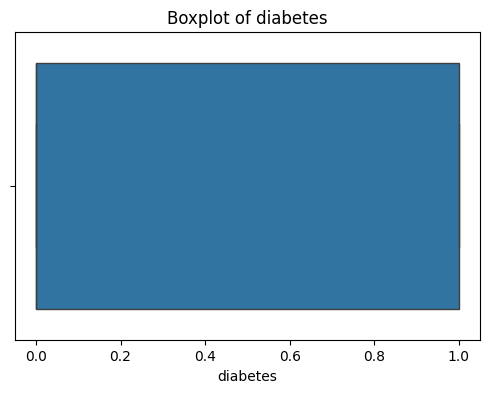

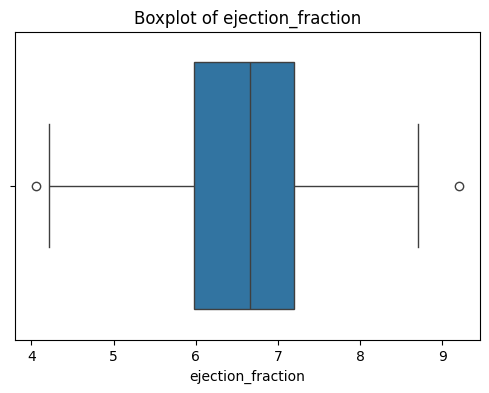

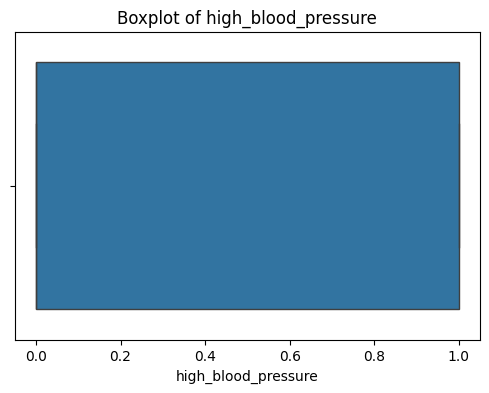

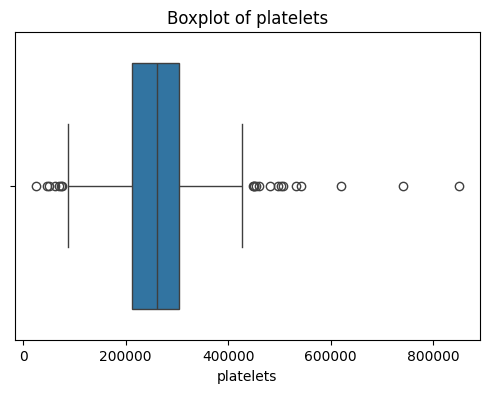

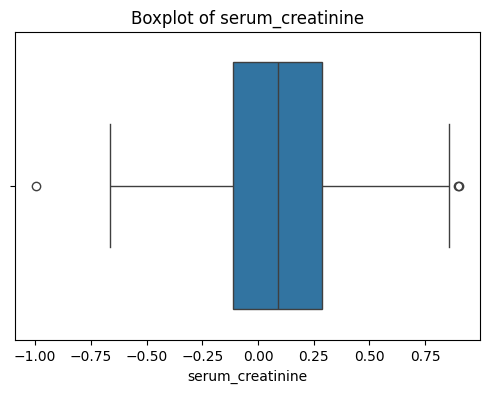

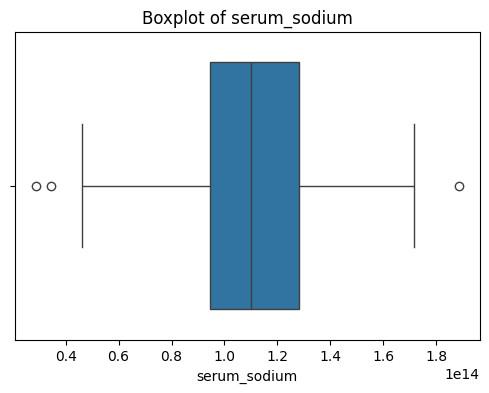

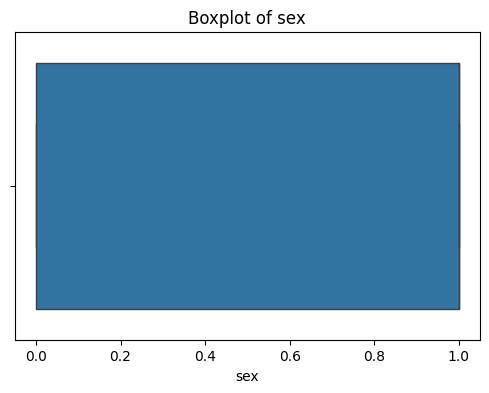

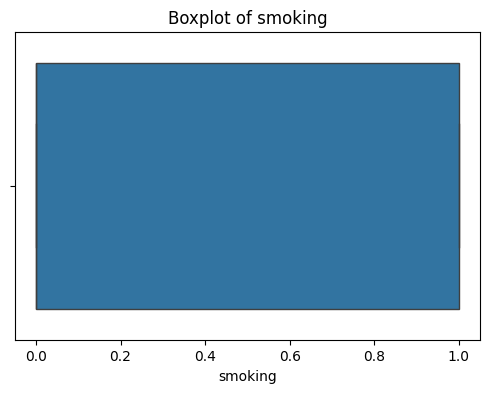

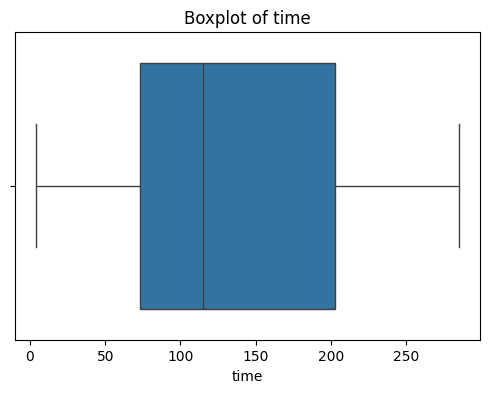

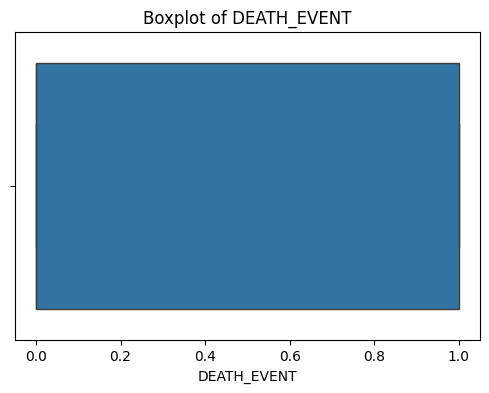

In [ ]:
# Loop through each numerical column and create a boxplot
for column in df_copy.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_copy[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

The Box-Cox method worked for all features except for **Patelets**, we need something more powerful 😃 !

Let's call **Winsorize** 😀🎃

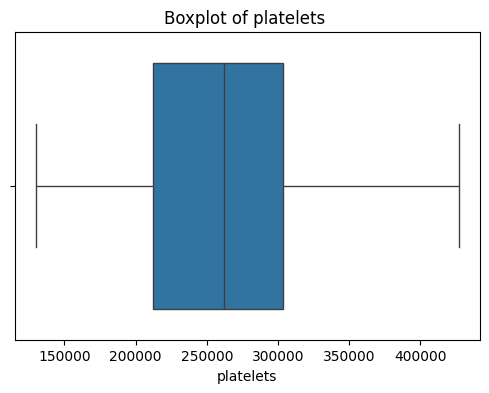

In [ ]:
df_copy['platelets'] = winsorize(df_copy['platelets'], limits=[0.05, 0.05])  # Capping at 5th and 95th percentiles

plt.figure(figsize=(6, 4))
sns.boxplot(x=df_copy['platelets'])
plt.title('Boxplot of platelets ')
plt.show()

Perfecto 👌🏼😃

In [ ]:
df_copy.platelets.describe()

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


,platelets
count,299.000000
mean,260143.647993
std,77042.234111
min,130000.000000
25%,212500.000000
50%,262000.000000
75%,303500.000000
max,427000.000000


## **The transformation panel for the input data (user interface)**

In [ ]:
def transform_input_data(input_data, data_before_trans, data_after_transf, cont_features, other_features, boxcox_lambdas):
    """
    Transforms new input data using precomputed transformations.

    - Applies Box-Cox transformation for continuous features using precomputed lambdas.
    - Applies Winsorization for 'platelets' based on original dataset percentiles.
    - Standardizes using precomputed mean and std from transformed data.

    Parameters:
    - input_data (pd.DataFrame): New input data to be transformed.
    - data_before_trans (pd.DataFrame): Dataset before transformations (used for Winsorization).
    - data_after_transf (pd.DataFrame): Dataset after transformations (used to extract mean & std for standardization).
    - cont_features (list): List of continuous features to apply Box-Cox.
    - other_features (list): List of features that should remain unchanged.
    - boxcox_lambdas (dict): Precomputed dictionary of Box-Cox lambda values for continuous features.

    Returns:
    - pd.DataFrame: Transformed and standardized input data.
    """
    data_transformed = input_data.copy()

    # Apply Box-Cox transformation to continuous features using precomputed lambdas
    for col in cont_features:
        if col in boxcox_lambdas and col in data_transformed.columns:
            lambda_val = boxcox_lambdas[col]
            data_transformed[col] = boxcox(data_transformed[col] + 1e-6, lambda_val)  # Avoid zero values

    # Apply Winsorization to 'platelets' using percentiles from data_before_trans
    if 'platelets' in data_transformed.columns and 'platelets' in data_before_trans.columns:
        lower_bound = np.percentile(data_before_trans['platelets'], 5)
        upper_bound = np.percentile(data_before_trans['platelets'], 95)
        data_transformed['platelets'] = np.clip(data_transformed['platelets'], lower_bound, upper_bound)

    # Ensure other features remain unchanged
    for col in other_features:
        if col in input_data.columns:
            data_transformed[col] = input_data[col]

    # Extract precomputed means and stds from data_after_transf
    stats = data_after_transf.describe().T
    means = stats["mean"]
    stds = stats["std"]

    # Standardize input data using precomputed mean & std
    for col in data_transformed.columns:
        if col != "DEATH_EVENT" and col in means and col in stds and stds[col] != 0:  # Avoid division by zero
            data_transformed[col] = (data_transformed[col] - means[col]) / stds[col]

    return data_transformed


In [ ]:
scaler = StandardScaler()
df_copy[features] = scaler.fit_transform(df_copy[features])

# **Imbalance handling using oversampling (Smote) & data separation**

We'll be applying the imbalance handling only for the training dataset 🛫

In [ ]:
X = df_copy.drop(columns=['DEATH_EVENT'])
Y = df_copy['DEATH_EVENT']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

In [ ]:
df_train = pd.DataFrame(X_train_resampled)
df_test = pd.DataFrame(X_test)

print("Training Set Statistics:")
print(df_train.describe())

print("\n Testing Set Statistics :")
print(df_test.describe())

Training Set Statistics:
              age     anaemia  creatinine_phosphokinase    diabetes  \
count  324.000000  324.000000                324.000000  324.000000   
mean     0.101359    0.052755                  0.035499    0.040623   
std      0.967305    0.985185                  0.973768    0.986151   
min     -1.754448   -0.871105                 -2.700345   -0.847579   
25%     -0.659702   -0.871105                 -0.706236   -0.847579   
50%     -0.011306   -0.871105                  0.053963   -0.847579   
75%      0.771889    1.147968                  0.690684    1.179830   
max      2.877170    1.147968                  2.406132    1.179830   

       ejection_fraction  high_blood_pressure   platelets  serum_creatinine  \
count         324.000000           324.000000  324.000000        324.000000   
mean           -0.162090             0.092081   -0.003682          0.130341   
std             1.028304             1.000394    0.995819          0.988996   
min            -2.5